In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [16]:
grid_roads = pd.read_pickle('data/grid_roads.pkl').reset_index(drop=True)
selected_GU = ['강남구']
selected_GU = ['서울특별시 ' + gu for gu in selected_GU]

seoul = gpd.read_file('data/seoul_geo/seoul.shp').to_crs(epsg=5174)
seoul_selected = seoul[seoul.SGG_NM.isin(selected_GU)]
roads_selected = gpd.sjoin(grid_roads, seoul_selected, op='intersects')
roads_selected = roads_selected.reset_index(drop=True)

roads_selected.drop(columns=['index_right'], inplace=True)

/Users/dangchan/miniforge3/envs/colab/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<Axes: >

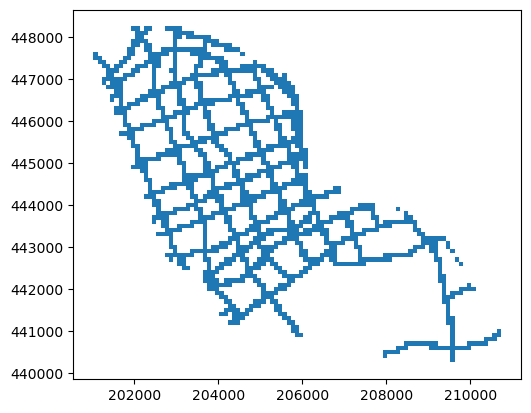

In [9]:
roads_selected.plot()

In [3]:
# flood = gpd.read_file('data/flood/서울시_2022.shp').to_crs(epsg=5174)

# flood.F_SAT_YMD = flood.F_SAT_YMD.str.replace('-','')
# flood.F_SAT_YMD = flood.F_SAT_YMD.astype(int)
# flood.F_END_YMD = flood.F_END_YMD.str.replace('-','')
# flood.F_END_YMD = flood.F_END_YMD.astype(int)

# # to datetime
# flood['START'] = pd.to_datetime(flood['F_SAT_YMD'], format='%Y%m%d') + pd.to_timedelta(flood.F_SAT_TM.astype(int), unit='h')
# flood['END'] = pd.to_datetime(flood['F_END_YMD'], format='%Y%m%d') + pd.to_timedelta(flood.F_END_TM.astype(int), unit='h')

# flood = flood[['START', 'END', 'geometry']]

# start_date = pd.to_datetime('2022-06-01')
# end_date = pd.to_datetime('2023-01-01')
# time_index = pd.date_range(start_date, end_date, freq='h')

# hourly_df = pd.DataFrame(index=time_index)
# # Initialize 'geometry' as a column of empty lists
# hourly_df['geometry'] = [[] for _ in range(len(hourly_df))]

# for _, row in tqdm(flood.iterrows(), total=flood.shape[0]):
#     start_time = row['START']
#     end_time = row['END']
#     geometry = row['geometry']

#     # Create a mask for the time index within the start and end times
#     mask = (hourly_df.index >= start_time) & (hourly_df.index <= end_time)

#     # Append the geometry to the lists in the 'geometry' column where the mask is True
#     hourly_df.loc[mask, 'geometry'] = hourly_df.loc[mask, 'geometry'].apply(lambda x: x + [geometry])

In [4]:
# # geometry list to unary union
# from shapely.ops import unary_union

# def to_unary_union(polygons):
#     if len(polygons) == 0:
#         return None
#     elif len(polygons) == 1:
#         return polygons[0]
#     else:
#         return unary_union(polygons)

# hourly_df['geometry'] = hourly_df['geometry'].apply(to_unary_union)

In [5]:
# hourly_df.to_pickle('data/hourly_flood.pkl')

In [17]:
# Now for each grid cell and each hour, check if the grid cell intersects with the flood geometry
hourly_df = pd.read_pickle('data/hourly_flood.pkl')
hourly_df = gpd.GeoDataFrame(hourly_df, geometry='geometry', crs='epsg:5174').reset_index()

joined = gpd.sjoin(hourly_df, roads_selected, op='intersects')

joined['flooded'] = 1

# Pivot the table to get a grid cell for each column and an hour for each row
pivoted = joined.pivot_table(index='index', columns='index_right', values='flooded', aggfunc='max')

# Fill NaN values with 0
pivoted = pivoted.fillna(0)

# Create a date range that covers the whole time series
complete_index = pd.date_range(start=hourly_df['index'].min(), end=hourly_df['index'].max(), freq='H')

# Reindex the pivoted DataFrame with the complete time series
pivoted = pivoted.reindex(complete_index)

# Create a complete set of grid cell indices
complete_columns = roads_selected.index.unique()

# Reindex the pivoted DataFrame with the complete set of grid cell indices
pivoted = pivoted.reindex(columns=complete_columns)

# Fill NaN values with 0
pivoted = pivoted.fillna(0)

/Users/dangchan/miniforge3/envs/colab/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/6r/ndnspf4n6n7_m8rb9bs7qdvr0000gp/T/ipykernel_25319/3431301713.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  complete_index = pd.date_range(start=hourly_df['index'].min(), end=hourly_df['index'].max(), freq='H')


In [18]:
pivoted.to_pickle('data/pivoted_flood.pkl')

In [19]:
# Likewise for the traffic data

months = [6, 7, 8, 9]
speed = pd.concat([
    pd.read_csv(f'data/speed/{month}.csv') for month in months
])

# 01시 - 24시
id_vars = ['일자', '링크아이디']
hour_idx = [f'{i:02}시' for i in range(1, 25)]

speed_long = speed.melt(id_vars=id_vars, value_vars=hour_idx, var_name='hour', value_name='speed')
speed_long.columns = ['date', 'LINK_ID', 'hour', 'speed']
speed_long = speed_long.pivot(index = ['date', 'hour'], columns='LINK_ID', values='speed')
speed_long.reset_index(inplace=True)
# date, hour to datetime
speed_long['datetime'] = pd.to_datetime(speed_long['date'], format='%Y%m%d') + pd.to_timedelta(speed_long['hour'].str.replace('시', '').astype(int), unit='h')
speed_long.drop(columns=['date', 'hour'], inplace=True)
speed_long.set_index('datetime', inplace=True)
speed_long.to_csv('data/traffic/speed_long.csv')
speed_long.head()

link = pd.read_excel('data/traffic/link.xlsx')
link = gpd.GeoDataFrame(link, geometry=gpd.points_from_xy(link['GRS80TM_X'], link['GRS80TM_Y']), crs='epsg:5174')

# Groupby LINK_ID and calculate the centroid of each link
from shapely.geometry import LineString

link_line = link.groupby('LINK_ID').apply(lambda x: LineString(x['geometry'].tolist())).reset_index()
link_line.columns = ['LINK_ID', 'geometry']
link_line = gpd.GeoDataFrame(link_line, crs='epsg:5174')

# For each grid cell, get the intersected LINK_IDs

grid = roads_selected.copy()

grid['LINK_ID'] = grid['geometry'].apply(lambda x: link_line[link_line.intersects(x)]['LINK_ID'].tolist())

/var/folders/6r/ndnspf4n6n7_m8rb9bs7qdvr0000gp/T/ipykernel_25319/2615615163.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  link_line = link.groupby('LINK_ID').apply(lambda x: LineString(x['geometry'].tolist())).reset_index()


In [20]:
# Unstack speed_long to get a long format DataFrame
speed_long_unstacked = speed_long.unstack().reset_index()
speed_long_unstacked.columns = ['LINK_ID', 'datetime', 'speed']

# Explode 'LINK_ID' column in grid
grid_exploded = grid.explode('LINK_ID').reset_index()

# Merge this DataFrame with grid
merged = pd.merge(speed_long_unstacked, grid_exploded[['LINK_ID', 'index']], on='LINK_ID')

# Group by the grid cell index and timestamp, and calculate the average speed for each group
grouped = merged.groupby(['index', 'datetime'])['speed'].mean().reset_index()

# Pivot the result so that the grid cell index is the column, timestamp is the row, and the values are the average speed
pivoted = grouped.pivot(index='datetime', columns='index', values='speed')

# Save
pivoted.to_pickle('data/pivoted_speed.pkl')

In [21]:
# Load the pivoted flood data and the pivoted speed data

pivoted_flood = pd.read_pickle('data/pivoted_flood.pkl')
pivoted_speed = pd.read_pickle('data/pivoted_speed.pkl')

# select pivoted_flood and pivoted_speed for the same time range with speed

pivoted_flood = pivoted_flood.loc[pivoted_speed.index]

pivoted_flood.to_pickle('data/pivoted_flood.pkl')